![Alt text](https://miro.medium.com/v2/resize:fit:1400/1*z-7KBjUIuDgLYqEav-f3Tw.png)

In [1]:
import open_clip
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_

# Majority Vote

### Process an image

In [2]:
import torch
import open_clip
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# Configuration
SLICE_SIZE = 160
OVERLAP = 0.3
VOTE_THRESHOLD = 3

In [4]:
# List of models to use
MODELS = [
    ('ViT-SO400M-14-SigLIP-384', 'webli'),
    ('ViT-H-14-378-quickgelu', 'dfn5b'),
    ('ViTamin-XL-384', 'datacomp1b'),
    ('ViT-bigG-14-CLIPA-336', 'datacomp1b'),
    ('EVA02-E-14-plus', 'laion2b_s9b_b144k'),
]

In [5]:
# Prompts for each class
PROMPTS = {
    'healthy': [
        "Green, normal-looking plant leaf or leaves",
        "Plant foliage appearing healthy and undamaged",
        "Leaf surface with natural color and texture",
        "Vibrant leaf or leaves without visible issues",
    ],
    'unhealthy': [
        "Plant leaf or leaves showing discoloration or spots",
        "Foliage with visible signs of disease or stress",
        "Leaf area with unusual texture or damage",
        "Plant leaves displaying abnormal colors or patterns",
    ],
    'background': [
        "Non-leaf elements such as soil, sky, or structures",
        "Area without any visible plant leaves",
        "Greenhouse materials or equipment",
        "Plant parts other than leaves, like fruits or stems",
        "Blurred or indistinct background elements",
    ]
}

In [6]:
def load_model(model_name, pretrained):
    """Load a model and its associated components."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained, device=device)
    model.eval()
    tokenizer = open_clip.get_tokenizer(model_name)
    return model, preprocess, tokenizer, device

def get_slices(image, slice_size, overlap):
    """Slice the image into overlapping patches."""
    height, width = image.shape[:2]
    stride = int(slice_size * (1 - overlap))
    slices = []
    positions = []
    
    for y in range(0, height - slice_size + 1, stride):
        for x in range(0, width - slice_size + 1, stride):
            slice = image[y:y+slice_size, x:x+slice_size]
            slices.append(slice)
            positions.append((x, y))
    
    return slices, positions

def classify_slices(model, preprocess, tokenizer, device, slices, prompts, model_name):
    """Classify each slice using the given model and prompts."""
    # Flatten the prompts dictionary into a list
    all_prompts = [prompt for class_prompts in prompts.values() for prompt in class_prompts]
    
    # Encode all prompts
    encoded_text = tokenizer(all_prompts).to(device)
    
    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = model.encode_text(encoded_text)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    
    results = []
    for slice in tqdm(slices, desc=f"Running {model_name}"):
        # Preprocess and encode the image slice
        image = preprocess(Image.fromarray(slice)).unsqueeze(0).to(device)
        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = model.encode_image(image)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            
            # Calculate similarity scores
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        
        # Calculate class scores
        class_scores = {}
        start_idx = 0
        for class_name, class_prompts in prompts.items():
            end_idx = start_idx + len(class_prompts)
            class_scores[class_name] = similarity[0, start_idx:end_idx].sum().item()
            start_idx = end_idx
        
        # Determine the predicted class
        predicted_class = max(class_scores, key=class_scores.get)
        results.append(predicted_class)
    
    # Clear GPU memory
    torch.cuda.empty_cache()
    return results

def draw_results(image, results, positions, slice_size):
    """Visualize the classification results on the image."""
    output = image.copy()
    colors = {
        'healthy': (0, 255, 0),  # Green
        'unhealthy': (255, 0, 0),  # Red
        'background': (0, 0, 255),  # Blue
        'undecided': (255, 255, 0)  # Yellow
    }
    
    for (x, y), result in zip(positions, results):
        color = colors.get(result, (128, 128, 128))  # Default to gray if class not found
        
        # Draw rectangle around the slice
        cv2.rectangle(output, (x, y), (x + slice_size, y + slice_size), (128, 128, 128), 2)
        
        # Draw the class label
        if result == 'undecided':
            label = 'X'
        else:
            label = result[0].upper()
        
        # Calculate text size and position
        text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)[0]
        text_x = x + (slice_size - text_size[0]) // 2
        text_y = y + (slice_size + text_size[1]) // 2
        
        cv2.putText(output, label, (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    
    return output

def majority_vote(all_results):
    """Perform majority voting across all model results."""
    votes = np.array(all_results)
    majority = []
    
    for slice_votes in votes.T:
        unique, counts = np.unique(slice_votes, return_counts=True)
        winner = unique[counts.argmax()]
        
        if counts.max() >= VOTE_THRESHOLD:
            majority.append(winner)
        else:
            majority.append('undecided')
    
    return majority

def process_image(image_path):
    """Process a single image through the entire pipeline."""
    # Load and convert the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Slice the image
    slices, positions = get_slices(image, SLICE_SIZE, OVERLAP)
    
    all_results = []
    fig, axs = plt.subplots(1, 6, figsize=(30, 5))
    
    # Process with each model
    for i, (model_name, pretrained) in enumerate(MODELS):
        model, preprocess, tokenizer, device = load_model(model_name, pretrained)
        results = classify_slices(model, preprocess, tokenizer, device, slices, PROMPTS, model_name)
        all_results.append(results)
        
        # Visualize results for this model
        output = draw_results(image, results, positions, SLICE_SIZE)
        axs[i].imshow(output)
        axs[i].set_title(model_name, fontsize=7)
        axs[i].axis('off')
        
        # Clear memory
        del model, preprocess, tokenizer
        torch.cuda.empty_cache()
    
    # Perform majority voting
    majority_results = majority_vote(all_results)
    
    # Visualize majority vote results
    majority_output = draw_results(image, majority_results, positions, SLICE_SIZE)
    axs[5].imshow(majority_output)
    axs[5].set_title('Majority Vote', fontsize=10)
    axs[5].axis('off')
    
    plt.tight_layout()
    plt.savefig('output.png', dpi=500, bbox_inches='tight')

Running ViTamin-XL-384: 100%|██████████| 40/40 [00:01<00:00, 28.01it/s]
/opt/conda/envs/pytorch/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Running EVA02-E-14-plus: 100%|██████████| 40/40 [00:02<00:00, 18.64it/s]


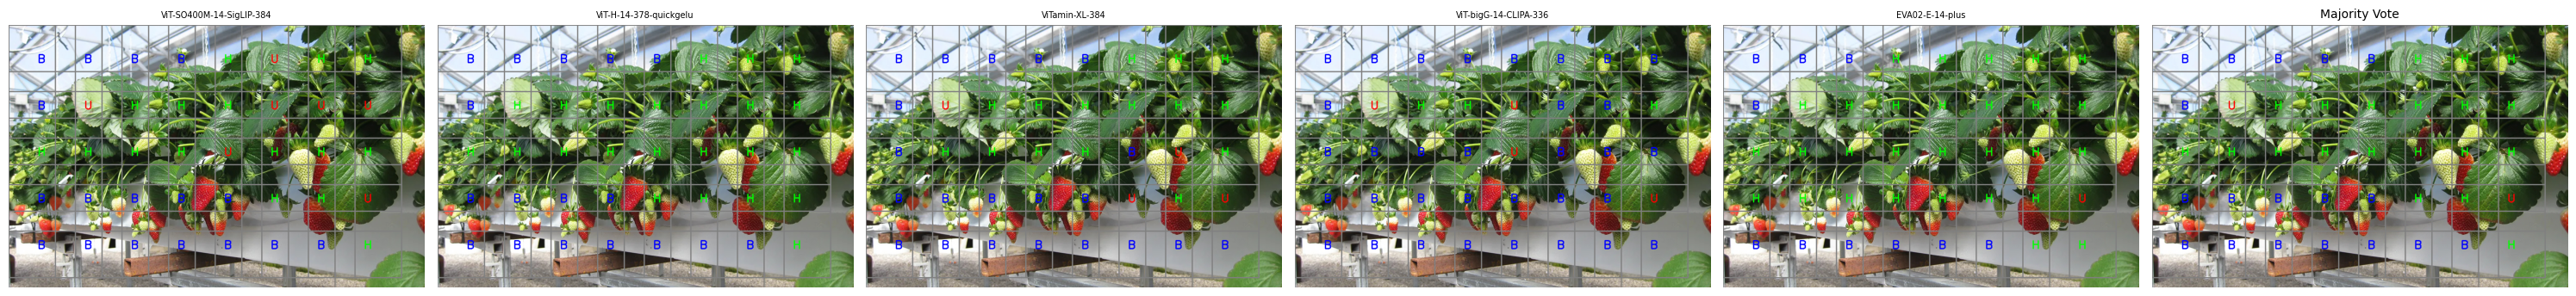

In [7]:
# Use this function to process an image
process_image("hort-americas-growing-hydroponic-strawberries.jpeg") # https://hortamericas.com/blog/news/essentials-for-growing-hydroponic-strawberries-successfully/

### Process a directory

In [ ]:
import os
import torch
import open_clip
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

In [ ]:
# Configuration
SLICE_SIZE_FHD = 384
SLICE_SIZE_LARGE = 256
OVERLAP = 0.2
VOTE_THRESHOLD = 3

In [ ]:
# List of models to use
MODELS = [
    ('ViT-SO400M-14-SigLIP-384', 'webli'),
    ('ViT-H-14-378-quickgelu', 'dfn5b'),
    ('ViTamin-XL-384', 'datacomp1b'),
    ('ViT-bigG-14-CLIPA-336', 'datacomp1b'),
    ('EVA02-E-14-plus', 'laion2b_s9b_b144k'),
]

In [ ]:
# Prompts for each class
PROMPTS = {
    'healthy': [
        "Green, normal-looking plant leaf or leaves",
        "Plant foliage appearing healthy and undamaged",
        "Leaf surface with natural color and texture",
        "Vibrant leaf or leaves without visible issues",
    ],
    'unhealthy': [
        "Plant leaf or leaves showing discoloration or spots",
        "Foliage with visible signs of disease or stress",
        "Leaf area with unusual texture or damage",
        "Plant leaves displaying abnormal colors or patterns",
    ],
    'background': [
        "Non-leaf elements such as soil, sky, or structures",
        "Area without any visible plant leaves",
        "Greenhouse materials or equipment",
        "Plant parts other than leaves, like fruits or stems",
        "Blurred or indistinct background elements",
    ]
}

In [ ]:
def load_model(model_name, pretrained):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained, device=device)
    model.eval()
    tokenizer = open_clip.get_tokenizer(model_name)
    return model, preprocess, tokenizer, device

def get_slices(image, overlap):
    height, width = image.shape[:2]
    
    # Determine slice size based on image resolution
    if height <= 1080 or width <= 1920:  # FHD or lower
        slice_size = SLICE_SIZE_FHD
    else:  # Larger than FHD
        slice_size = SLICE_SIZE_LARGE
    
    stride = int(slice_size * (1 - overlap))
    slices = []
    positions = []
    
    for y in range(0, height - slice_size + 1, stride):
        for x in range(0, width - slice_size + 1, stride):
            slice = image[y:y+slice_size, x:x+slice_size]
            slices.append(slice)
            positions.append((x, y))
    
    return slices, positions, slice_size

def classify_slices(model, preprocess, tokenizer, device, slices, prompts):
    all_prompts = [prompt for class_prompts in prompts.values() for prompt in class_prompts]
    encoded_text = tokenizer(all_prompts).to(device)
    
    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = model.encode_text(encoded_text)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    
    results = []
    for slice in slices:
        image = preprocess(Image.fromarray(slice)).unsqueeze(0).to(device)
        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = model.encode_image(image)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        
        class_scores = {}
        start_idx = 0
        for class_name, class_prompts in prompts.items():
            end_idx = start_idx + len(class_prompts)
            class_scores[class_name] = similarity[0, start_idx:end_idx].sum().item()
            start_idx = end_idx
        
        predicted_class = max(class_scores, key=class_scores.get)
        results.append(predicted_class)
    
    return results

def draw_results(image, results, positions, slice_size):
    output = image.copy()
    colors = {
        'healthy': (0, 255, 0),
        'unhealthy': (255, 0, 0),
        'background': (0, 0, 255),
        'undecided': (255, 255, 0)
    }
    
    for (x, y), result in zip(positions, results):
        color = colors.get(result, (128, 128, 128))
        cv2.rectangle(output, (x, y), (x + slice_size, y + slice_size), (128, 128, 128), 2)
        label = 'X' if result == 'undecided' else result[0].upper()
        text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)[0]
        text_x = x + (slice_size - text_size[0]) // 2
        text_y = y + (slice_size + text_size[1]) // 2
        cv2.putText(output, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    
    return output

def majority_vote(all_results):
    votes = np.array(all_results)
    majority = []
    
    for slice_votes in votes.T:
        unique, counts = np.unique(slice_votes, return_counts=True)
        winner = unique[counts.argmax()]
        
        if counts.max() >= VOTE_THRESHOLD:
            majority.append(winner)
        else:
            majority.append('undecided')
    
    return majority

def process_image(image_path, output_dir):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    slices, positions, slice_size = get_slices(image, OVERLAP)
    
    all_results = []
    fig, axs = plt.subplots(1, 6, figsize=(30, 5))
    
    for i, (model_name, pretrained) in enumerate(MODELS):
        model, preprocess, tokenizer, device = load_model(model_name, pretrained)
        results = classify_slices(model, preprocess, tokenizer, device, slices, PROMPTS)
        all_results.append(results)
        
        output = draw_results(image, results, positions, slice_size)
        axs[i].imshow(output)
        axs[i].set_title(model_name, fontsize=7)
        axs[i].axis('off')
        
        del model, preprocess, tokenizer
        torch.cuda.empty_cache()
        gc.collect()
    
    majority_results = majority_vote(all_results)
    
    majority_output = draw_results(image, majority_results, positions, slice_size)
    axs[5].imshow(majority_output)
    axs[5].set_title('Majority Vote', fontsize=10)
    axs[5].axis('off')
    
    plt.tight_layout()
    
    output_filename = os.path.join(output_dir, os.path.basename(image_path).rsplit('.', 1)[0] + '_output.png')
    plt.savefig(output_filename, dpi=500, bbox_inches='tight')
    plt.close(fig)

def process_directory(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    image_extensions = ['.jpg', '.jpeg', '.png']
    image_files = [f for f in os.listdir(input_dir) if os.path.splitext(f.lower())[1] in image_extensions]
    
    for image_file in tqdm(image_files, desc="Processing images"):
        image_path = os.path.join(input_dir, image_file)
        process_image(image_path, output_dir)
        torch.cuda.empty_cache()
        gc.collect()

In [ ]:
# Specify the input and output directories
input_directory = "/home/jupyter/thesis_samples"
output_directory = "/home/jupyter/thesis_output"

# Process all images in the input directory and save results in the output directory
process_directory(input_directory, output_directory)